## Imports and reading the data

In [1]:
# ocr using pytesseract
!sudo apt install tesseract-ocr
!pip install pytesseract
import pytesseract
# ocr using easyocr
!pip install easyocr
import easyocr
import os
import numpy as np
import pandas as pd
import re, nltk
nltk.download('words')
from nltk.tokenize import RegexpTokenizer
import cv2
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
import matplotlib.pyplot as plt

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (30.9 MB/s)
debconf: unable to initia

Using TensorFlow backend.


In [2]:
base_dir=r'/content/drive/My Drive/Hackerearth pride data'
test_images=os.path.join(base_dir,'Dataset')
test_csv=os.path.join(base_dir,'Test.csv')

In [3]:
data=pd.read_csv(test_csv)
data.head()

,Filename,Category
0,Test1001.jpg,NaN
1,Test1012.jpg,NaN
2,Test1022.jpg,NaN
3,Test1071.jpg,NaN
4,Test1122.jpg,NaN


In [4]:
data.shape

(239, 2)

In [5]:
path=os.path.join(test_images,data['Filename'][0])

### Reading text through pytesseract

In [6]:
img = cv2.imread(path)

# Adding custom options
custom_config = r'--oem 3 --psm 6'
pytesseract.image_to_string(img, config=custom_config)

"When people ask\nwhat I see in you,\nI just smile and\nlook away because\nI'm afraid if they knew,\nthey'd fall in love\nwith you too."

### Reading text through easyocr

In [7]:
reader = easyocr.Reader(['en'])
reader.readtext(img)

Download complete
Download complete


[([[32, 14], [208, 14], [208, 42], [32, 42]],
  'When people ask',
  0.8024377822875977),
 ([[30, 38], [214, 38], [214, 64], [30, 64]],
  'what Isee in you,',
  0.07900962978601456),
 ([[42, 60], [204, 60], [204, 88], [42, 88]],
  'Ijust smile and',
  0.15037031471729279),
 ([[28, 83], [216, 83], [216, 113], [28, 113]],
  'look away because',
  0.785081684589386),
 ([[8, 104], [248, 104], [248, 134], [8, 134]],
  'Im afraid ifthey knew,',
  0.5500624775886536),
 ([[36, 130], [216, 130], [216, 158], [36, 158]],
  'theyd fall in love',
  0.7659639716148376),
 ([[60, 154], [196, 154], [196, 182], [60, 182]],
  'with you too.',
  0.25999242067337036)]

In [8]:
temp=reader.readtext(img)
string = " ".join(t[1] for t in temp)
string

'When people ask what Isee in you, Ijust smile and look away because Im afraid ifthey knew, theyd fall in love with you too.'

## Functions for image preprocessing

In [9]:
img.shape

(197, 256, 3)

In [10]:
def deskew(image):
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(image)
    thresh = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)    
    return rotated

In [11]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

In [12]:
def image_preprocessing_for_ocr(img):
    kernel = np.ones((1,1),np.uint8)

    # Resizing
    img = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC)

    # get grayscale image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # dilation
    img = cv2.dilate(img, kernel, iterations = 1)

    # erosion
    img = cv2.erode(img, kernel, iterations = 1)

    # noise removal using median blur
    cv2.threshold(cv2.medianBlur(img, 3), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    #gamma correction
    #img = adjust_gamma(img,0.8)

    #skew correction
    #img = deskew(img)

    return img

## OCR (without any image preprocessing) using pytesseract

In [42]:
text_from_images=[]
# Adding custom options
#custom_config = r'--oem 3 --psm 6'
#custom_config = r'--psm 7'
for i in data.index:
    path = os.path.join(test_images,data['Filename'][i])
    # Reading the image
    img = cv2.imread(path)

    # Preprocessing the image
    #img = image_preprocessing_for_ocr(img)

    # Extracting the text
    #text = pytesseract.image_to_string(img, config= custom_config,lang='eng')
    text = pytesseract.image_to_string(img, lang='eng')

    # Appending to the list
    text_from_images.append(text)

In [54]:
data['Content'] = text_from_images
data.head()

,Filename,Category,Content
0,Test1001.jpg,NaN,"When people ask\nwhat I see in you,\nI just sm..."
1,Test1012.jpg,NaN,LOVE\nocd)\naie al\nRao
2,Test1022.jpg,NaN,LOVE\n®
3,Test1071.jpg,NaN,eee MU WALLA OL\n\nem eat nimeel ie\n\nnot liv...
4,Test1122.jpg,NaN,"‘Zeigler, author of ""Fair Play: How LGBT Athle..."


In [55]:
data['Content']=data['Content'].apply(lambda x:re.sub(r'\n',' ',x))
website=r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
data['Content']=data['Content'].apply(lambda x:re.sub(website,'',x))
words = set(nltk.corpus.words.words())
data['Content']=data['Content'].apply(lambda x:" ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words))

In [56]:
data.head()

,Filename,Category,Content
0,Test1001.jpg,NaN,When people ask what I see in you I just smile...
1,Test1012.jpg,NaN,LOVE al
2,Test1022.jpg,NaN,LOVE
3,Test1071.jpg,NaN,MU em eat ie not living by society s but deep ...
4,Test1122.jpg,NaN,author of Fair Play How are their Rightful Pla...


- Cleaning the text to remove unwanted data.

## OCR (without any image preprocessing) using easyocr

In [57]:
filename,category,content=[],[],[]
for i in data.index:
    if(data['Content'][i]=='' or len(data['Content'][i].split())==1 or len(data['Content'][i].split())==2):
        filename.append(data['Filename'][i])
        category.append(data['Category'][i])
        content.append(data['Content'][i])
data_with_no_text_dict={'Filename':filename,'Category':category,'Content':content}
data_with_no_text=pd.DataFrame(data_with_no_text_dict)
data_with_no_text.head()

,Filename,Category,Content
0,Test1012.jpg,NaN,LOVE al
1,Test1022.jpg,NaN,LOVE
2,Test1161.jpg,NaN,
3,Test1279.jpg,NaN,
4,Test1290.jpg,NaN,


In [58]:
text_from_remaining_images=[]
# Adding custom options
#custom_config = r'--oem 3 --psm 6'
#custom_config = r'--psm 7'
for i in data_with_no_text.index:
    path = os.path.join(test_images,data_with_no_text['Filename'][i])
    # Reading the image
    img = cv2.imread(path)

    # Preprocessing the image
    #img = image_preprocessing_for_ocr(img)

    # Extracting the text
    temp = reader.readtext(img)
    text = " ".join(t[1] for t in temp)

    # Appending to the list
    text_from_remaining_images.append(text)

In [59]:
data_with_no_text['Content'] = text_from_remaining_images

In [60]:
for i in data_with_no_text.index:
    if data_with_no_text['Content'][i]!='':
        for j in data.index:
            if data['Filename'][j]==data_with_no_text['Filename'][i]:
                data['Content'][j]=data_with_no_text['Content'][i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [61]:
data['Content']=data['Content'].apply(lambda x:re.sub(r'\n',' ',x))
website=r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
data['Content']=data['Content'].apply(lambda x:re.sub(website,'',x))

In [62]:
len(data[data['Content']==''])

53

- Number of images with no content

In [63]:
data.head()

,Filename,Category,Content
0,Test1001.jpg,NaN,When people ask what I see in you I just smile...
1,Test1012.jpg,NaN,LovE Is To0 BEAunIL TO gE HlDDl3l IN THE CLOSIs
2,Test1022.jpg,NaN,LOV is aeve
3,Test1071.jpg,NaN,MU em eat ie not living by society s but deep ...
4,Test1122.jpg,NaN,author of Fair Play How are their Rightful Pla...


In [64]:
data.tail()

,Filename,Category,Content
234,Test243.jpg,NaN,FREEDOM mo Middle
235,Test244.jpg,NaN,
236,Test245.jpg,NaN,Anti Bullying that have bullying of on the bas...
237,Test249.jpg,NaN,IN
238,Test250.jpg,NaN,5 BESTGAY QUOTES BL0 G NE T


## Training a model on Twitter sentiment classification data

In [201]:
train=pd.read_csv(r'/content/drive/My Drive/Sentiment Analysis Dataset.csv', skiprows=[8835, 535881])
#train=train.iloc[:1000000,:]
train.head()

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [202]:
train.shape

(1578612, 4)

In [203]:
tweets = train['SentimentText']
labels = train['Sentiment']

1    790177
0    788435
Name: Sentiment, dtype: int64


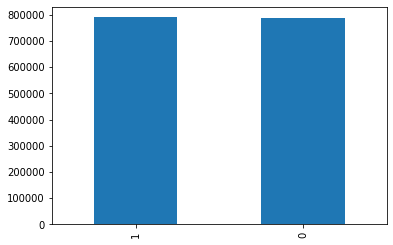

In [204]:
labels_count = labels.value_counts()
labels_count.plot(kind="bar")
print(labels.value_counts())

In [205]:
tkr = RegexpTokenizer('[a-zA-Z@]+')
tweets_split = []
for i, line in enumerate(tweets):
    #print(line)
    tweet = str(line).lower().split()
    tweet = tkr.tokenize(str(tweet))
    tweets_split.append(tweet)

### Downloading the Glove(Global vectors for word representation) file for creating the embedding matrix

In [70]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-07-20 08:39:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-07-20 08:39:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-07-20 08:39:25--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [71]:
!unzip /content/glove.6B.zip

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [72]:
embeddings_index = {}
f = open(r'/content/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

- Creating an embedding dictionary.

In [73]:
print('Total number of word vectors are:' , len(embeddings_index))

Total number of word vectors are: 400000


In [74]:
max_words = len(embeddings_index)
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
count = 0
for word, i in embeddings_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[count] = embedding_vector
        count+=1

- Creating an embedding matrix to be used as weights for the embedding layer in the model.

### Text preprocessing

In [206]:
#Convert words to integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets_split)
text = tokenizer.texts_to_sequences(tweets_split)

In [207]:
#lenght of tweet to consider
maxlentweet = 40
#add padding
text = pad_sequences(text, maxlen=maxlentweet)
print(text.shape)

(1578612, 40)


In [208]:
train_size=int(text.shape[0]-text.shape[0]*0.20)
train_x=text[:train_size]
train_y=labels[:train_size]
val_x=text[train_size:]
val_y=labels[train_size:]

### Defining and training the model

In [209]:
model=models.Sequential()
model.add(layers.Embedding(max_words,embedding_dim,input_length=maxlentweet))
model.add(layers.LSTM(units=80))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 40, 100)           40000000  
_________________________________________________________________
lstm_7 (LSTM)                (None, 80)                57920     
_________________________________________________________________
dropout_7 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 81        
Total params: 40,058,001
Trainable params: 40,058,001
Non-trainable params: 0
_________________________________________________________________
None


In [210]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 40, 100)           40000000  
_________________________________________________________________
lstm_7 (LSTM)                (None, 80)                57920     
_________________________________________________________________
dropout_7 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 81        
Total params: 40,058,001
Trainable params: 58,001
Non-trainable params: 40,000,000
_________________________________________________________________
None


In [211]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(1e-3), 
              metrics=['accuracy'])

In [155]:
earlystopper = EarlyStopping(patience=6, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=1e-6, verbose=1)

- Defining the callbacks.

In [212]:
history=model.fit(train_x,
                  train_y,
                  epochs=60,
                  batch_size=2048,
                  validation_data=[val_x,val_y],
                  callbacks=[earlystopper,reduce_lr])

Train on 1262889 samples, validate on 315723 samples
Epoch 1/60
1262889/1262889 [==============================] - 85s 68us/step - loss: 0.6307 - accuracy: 0.6397 - val_loss: 0.5838 - val_accuracy: 0.6919
Epoch 2/60
1262889/1262889 [==============================] - 84s 67us/step - loss: 0.5733 - accuracy: 0.6986 - val_loss: 0.5359 - val_accuracy: 0.7269
Epoch 3/60
1262889/1262889 [==============================] - 84s 67us/step - loss: 0.5408 - accuracy: 0.7244 - val_loss: 0.5064 - val_accuracy: 0.7508
Epoch 4/60
1262889/1262889 [==============================] - 85s 67us/step - loss: 0.5219 - accuracy: 0.7388 - val_loss: 0.4911 - val_accuracy: 0.7627
Epoch 5/60
1262889/1262889 [==============================] - 84s 67us/step - loss: 0.5091 - accuracy: 0.7490 - val_loss: 0.4925 - val_accuracy: 0.7611
Epoch 6/60
1262889/1262889 [==============================] - 84s 67us/step - loss: 0.4973 - accuracy: 0.7564 - val_loss: 0.4688 - val_accuracy: 0.7786
Epoch 7/60
1262889/1262889 [=======

In [213]:
model.save(r'/content/drive/My Drive/Hackerearth pride data/Love is love - Hackerearth - Final.h5')
#model=models.load_model('/content/drive/My Drive/Hackerearth pride data/Love is love - Hackerearth - Final.h5')

In [ ]:
#tf.keras.backend.clear_session()

<Figure size 432x288 with 0 Axes>

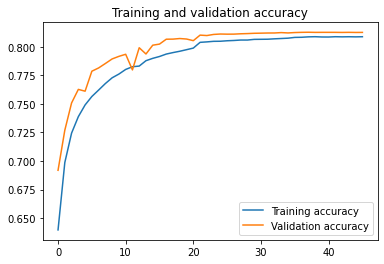

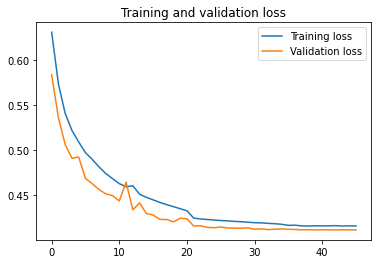

<Figure size 432x288 with 0 Axes>

In [214]:
acc      = history.history[ 'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot( epochs, acc , label = 'Training accuracy')
plt.plot( epochs, val_acc, label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot( epochs, loss , label = 'Training loss')
plt.plot( epochs, val_loss, label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

## Making predictions for the text extracted through OCR

In [215]:
data_without_random=data[data['Content']!='']

In [216]:
data_without_random.shape

(186, 3)

In [217]:
data.shape

(239, 3)

In [218]:
content = tokenizer.texts_to_sequences(data_without_random['Content'])
#add padding
content = pad_sequences(content, maxlen=maxlentweet)
print(content.shape)

(186, 40)


In [219]:
predictions=model.predict_classes(content)

In [220]:
data_without_random['Category']=predictions
data_without_random['Category']=data_without_random['Category'].apply(lambda x:'Negative' if x==0 else 'Positive')
data_without_random.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Filename,Category,Content
0,Test1001.jpg,Positive,When people ask what I see in you I just smile...
1,Test1012.jpg,Positive,LovE Is To0 BEAunIL TO gE HlDDl3l IN THE CLOSIs
2,Test1022.jpg,Positive,LOV is aeve
3,Test1071.jpg,Negative,MU em eat ie not living by society s but deep ...
4,Test1122.jpg,Positive,author of Fair Play How are their Rightful Pla...


In [221]:
data_without_random['Category'].value_counts()

Positive    131
Negative     55
Name: Category, dtype: int64

In [222]:
Category=[]
for i in data.index:
    if data['Content'][i]=='':
        Category.append('Random')
    else:
        for j in data_without_random.index:
            if data['Filename'][i]==data_without_random['Filename'][j]:
                Category.append(data_without_random['Category'][j])

In [223]:
data['Category']=Category
data.head()

,Filename,Category,Content
0,Test1001.jpg,Positive,When people ask what I see in you I just smile...
1,Test1012.jpg,Positive,LovE Is To0 BEAunIL TO gE HlDDl3l IN THE CLOSIs
2,Test1022.jpg,Positive,LOV is aeve
3,Test1071.jpg,Negative,MU em eat ie not living by society s but deep ...
4,Test1122.jpg,Positive,author of Fair Play How are their Rightful Pla...


In [224]:
final_submission=data[['Filename','Category']]
final_submission.head()

,Filename,Category
0,Test1001.jpg,Positive
1,Test1012.jpg,Positive
2,Test1022.jpg,Positive
3,Test1071.jpg,Negative
4,Test1122.jpg,Positive


In [225]:
final_submission['Category'].value_counts()

Positive    131
Negative     55
Random       53
Name: Category, dtype: int64

In [226]:
final_submission.to_csv(r'/content/drive/My Drive/Hackerearth pride data/final_submission.csv',index=False)